
# Dialect classification

### Install and import necessary packages

In [56]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from torch import nn
from transformers import Trainer

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1, 1, 1, 1, 1, 1, 0.38, 1, 0.66, 1, 1]))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [58]:
import torch
import numpy as np
import pandas as pd
import datasets
from collections import Counter
from datasets import load_dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Load data

#### import data

In [59]:
torch.cuda.is_available()
device = torch.device("cuda")
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/eth_CS4NLP/project/qadata'
train_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_train_2.csv'
dev_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_dev.txt'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
final_dev.csv	    pred_bert_output	   vardial_train_1.csv
final_train.csv     Record_outputs.gsheet  vardial_train_2.csv
final_train.gsheet  vardial_dev.txt
output		    vardial_test.txt


In [60]:
#IMPORT devset
dial_label = {
    0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'
}

fold_label = {
    'EML' : 0,
    'NAP' : 1,
    'PMS' : 2,
    'FUR' : 3,
    'LLD' : 4,
    'LIJ' : 5,
    'LMO' : 6,
    'ROA_TARA' : 7,
    'SCN' : 8,
    'VEC' : 9,
    'SC' : 10
}

def explain_label(label : int) -> str:
    """ 
    Given an integer label, convert it to the corresponding string label
    :param int label: integer label to be converted
    :return: string corresponding to the given label
    """
    return dial_label[label]

def encode_label(label : str) -> int:
    """ 
    Given a string label, encode it to the corresponding index
    :param string label: string label to be converted
    :return: int corresponding to the given label
    """
    return fold_label[label]

In [61]:
df_dev = pd.read_csv(dev_path, sep = "\t", names=["label", "text"])
df_dev['label'] = df_dev['label'].apply(encode_label)
df_dev = df_dev.fillna('')
#-
df_train = pd.read_csv(train_path)
df_train_=df_train[['text','label']]
df_train_.drop_duplicates(subset ='text',keep = False, inplace = True, ignore_index=True) 
#SUBSET
#f_train_ = df_train_.iloc[0:1000,:] 

In [62]:
df_train_.head(2)

,text,label
0,Al funsiòuna da 'l 11 ed novèmber dal 2016.,0
1,Al 2017 'l è 'n an dal XXI sécol dal Calendàr...,0


In [63]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(id2label)
print(id2label)

{0: 'EML', 1: 'NAP', 2: 'PMS', 3: 'FUR', 4: 'LLD', 5: 'LIJ', 6: 'LMO', 7: 'ROA_TARA', 8: 'SCN', 9: 'VEC', 10: 'SC'}


In [64]:
from datasets import Dataset
train_ds = Dataset.from_pandas(df_train_)
dev_ds = Dataset.from_pandas(df_dev)
# Example of instance of the dataset
train_ds[18]

{'label': 0,
 'text': "Una gita scolastica  all'è un film dal 1983 dirigì da Pupi Avati."}

## Tokenizing data

In [65]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

#### model_name
-  m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0
-  'dbmdz/bert-base-italian-cased'
- [x] 'dbmdz/bert-base-italian-xxl-cased'
- 'dbmdz/bert-base-italian-uncased'
- mrm8488/bert-italian-finedtuned-squadv1-it-alfa

In [66]:

# Load BERT tokenizer.
#model_name = 'xlnet-large-cased'
model_name = 'dbmdz/bert-base-italian-xxl-cased'


In [67]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/dbmdz/bert-base-italian-xxl-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a6f63287bf77965c2a075e2eb7b021b66b863c245cb1ac8cd51d73c9b9711f11.d4216e94150242f24c22ebc3ff97fb4079388b3e36c7e029e29e0f833f5db329
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-italian-xxl-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32102
}

loading file https://huggingface.co/dbmdz/bert-base-italian-xxl-cas

In [68]:

def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['text'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=70)
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['label']]))
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [69]:
# Tokenizing datasets
encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_test = encode_dataset(dev_ds)

# Fine tunning of the model

In [70]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_dir='logs',
    no_cuda=False,  
    output_dir = 'drive/MyDrive/eth_CS4NLP/project',
)

# Dictionary to save the results
models_performance ={}

# FINE TUNING PROCESS

# create model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,)

for param in model.bert.parameters(): #frozee the BERT layers
    param.requires_grad = True
    '''
#all(p.requires_grad for p in model.parameters()
'''


# Create trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=encoded_dataset_train,)

# Fine tunning
trainer.train()


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/dbmdz/bert-base-italian-xxl-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/a6f63287bf77965c2a075e2eb7b021b66b863c245cb1ac8cd51d73c9b9711f11.d4216e94150242f24c22ebc3ff97fb4079388b3e36c7e029e29e0f833f5db329
Model config BertConfig {
  "_name_or_path": "dbmdz/bert-base-italian-xxl-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
  

Step,Training Loss
500,0.290200
1000,0.116000
1500,0.093000
2000,0.083400
2500,0.077600
3000,0.072400
3500,0.045800
4000,0.046900
4500,0.040500
5000,0.040400


Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-500
Configuration saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/config.json
Model weights saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-500/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-1000
Configuration saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/eth_CS4NLP/project/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to drive/MyDrive/eth_CS4NLP/project/checkpoint-1500
Configuration saved i

TrainOutput(global_step=6076, training_loss=0.08090674331739123, metrics={'train_runtime': 4607.3125, 'train_samples_per_second': 168.767, 'train_steps_per_second': 1.319, 'total_flos': 2.797288736157804e+16, 'train_loss': 0.08090674331739123, 'epoch': 2.0})

In [79]:
# Get the predicted labels
preds = trainer.predict(encoded_dataset_test)
predictions = preds.predictions.argmax(-1)

# Create array with predicted labels and expected.
true_values = np.array(preds.label_ids).flatten()
predicted_values = np.array(preds.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')

***** Running Prediction *****
  Num examples = 6801
  Batch size = 128


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
model_performance

{'accuracy': 0.8931039553006911,
 'confusion_matrix': array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    1, 1177,    0,    0,    2,   10,    0,    0,    1,    0],
        [   0,    1,    1,  666,    0,    1,    1,    1,    2,    1,    2],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    1,    0,    0,    0,  606,   10,    0,    0,    0,    0],
        [   4,   10,   12,    1,    1,    5, 1157,    2,   10,   23,    6],
        [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   0,   30,    2,    1,    0,    4,   15,    0, 1280,    8,   32],
        [   1,   27,    9,    2,    7,   64,  301,    4,   13,  797,   12],
        [   0,    3,    1,    1,    2,   15,    5,    0,   59,    0,  391]]),
 'confusion_matrix_normalized': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
     

# Models evaluation

F1-micro and F1-macro for each model

In [81]:
print('------------Model performance------------')
print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')
print()

------------Model performance------------
  accuracy: 0.8931039553006911
  f1-micro: 0.8931039553006911
  f1-macro: 0.5726725945912143



To understan better the performance of the classifier, we display the confusion matrix:

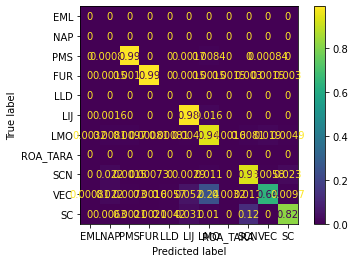

In [82]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'],display_labels = list(id2label.values()))
disp.plot()

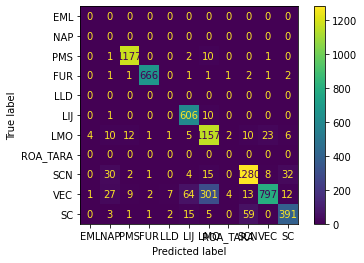

In [83]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
disp.plot()

In [84]:
pred_df = pd.DataFrame({'pred_label':predicted_values})
pred_df

,pred_label
0,6
1,8
2,6
3,9
4,5
...,...
6796,9
6797,8
6798,8
6799,8


In [85]:
df_dev.shape

(6801, 2)

In [78]:
from google.colab import files
pred_df.to_csv('pred_bert_dbmdz_bert-base-italian-xxl-cased.csv',index=False)
files.download('pred_bert_dbmdz_bert-base-italian-xxl-cased.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>